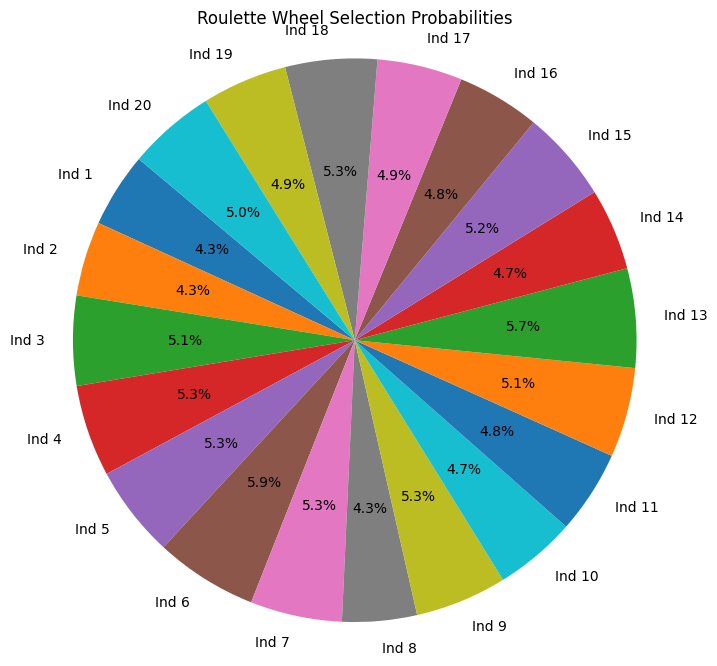

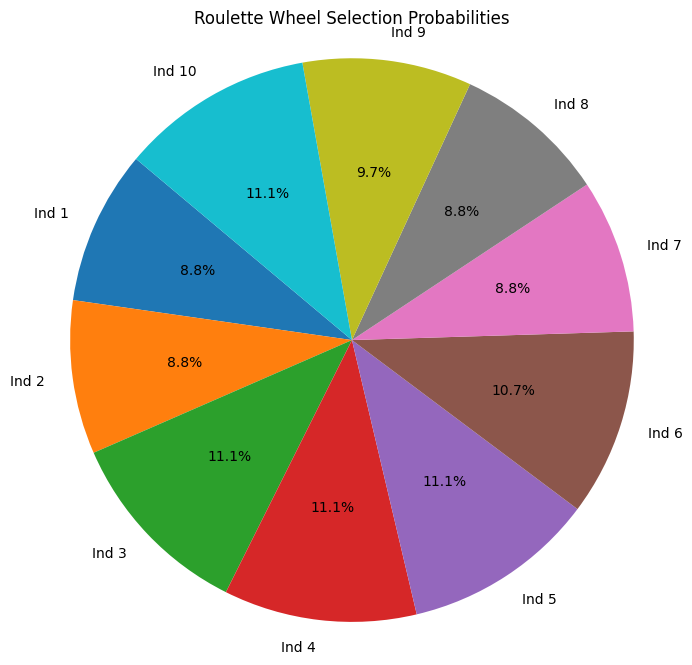

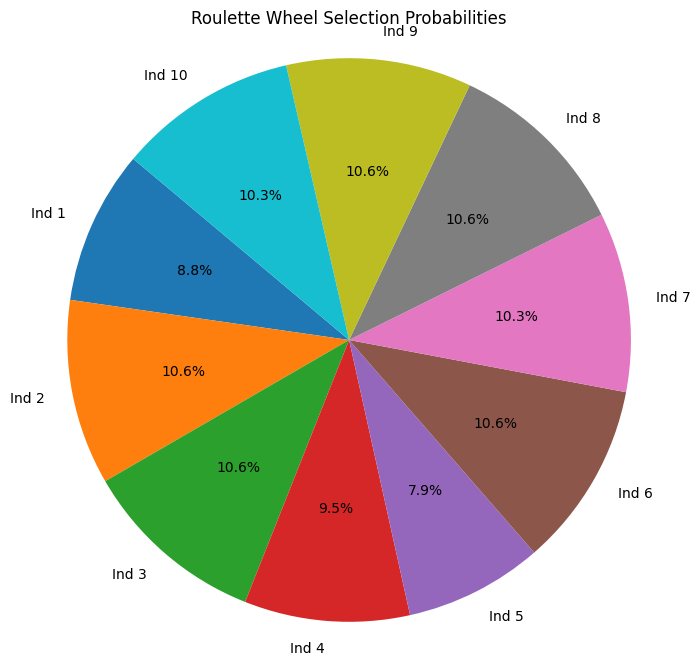

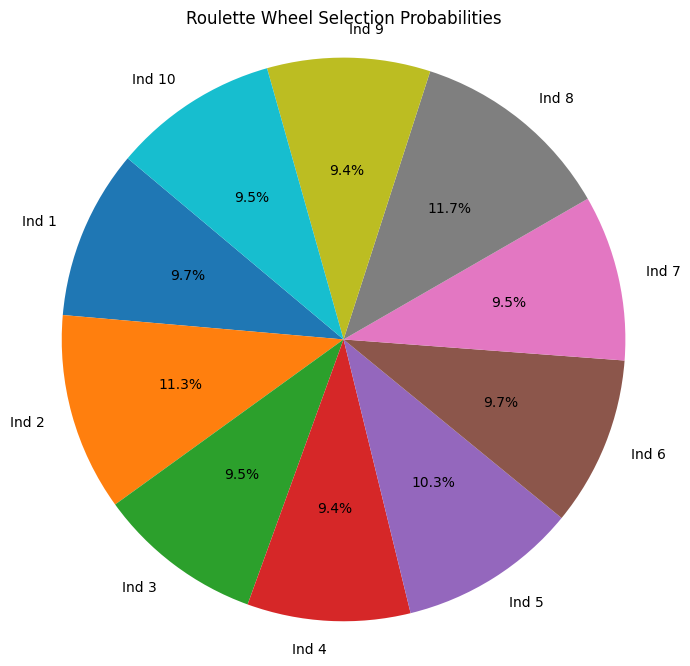

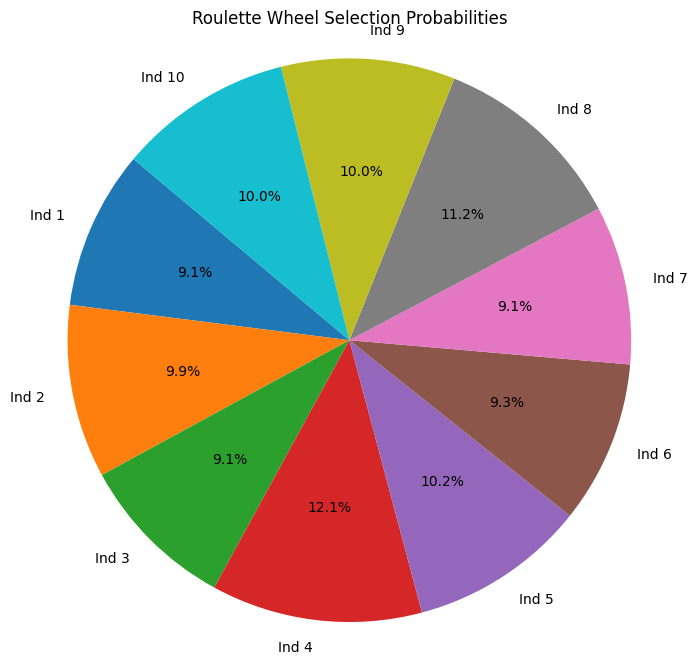

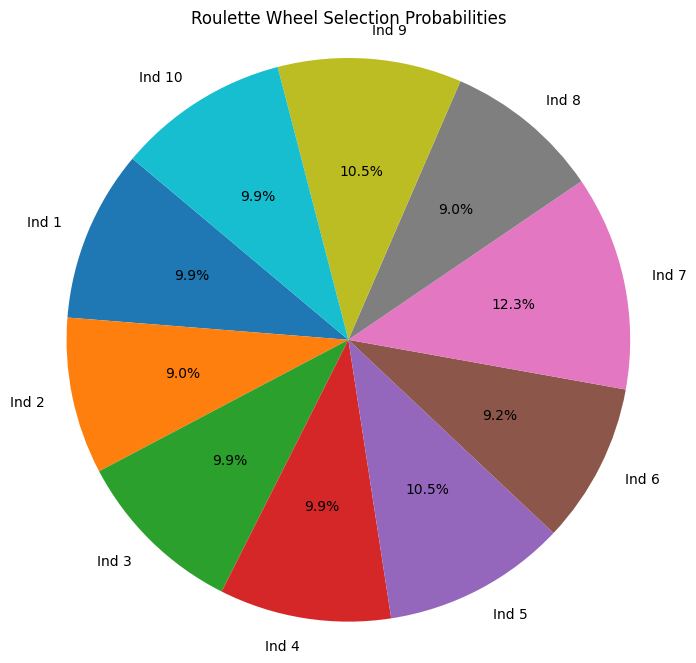

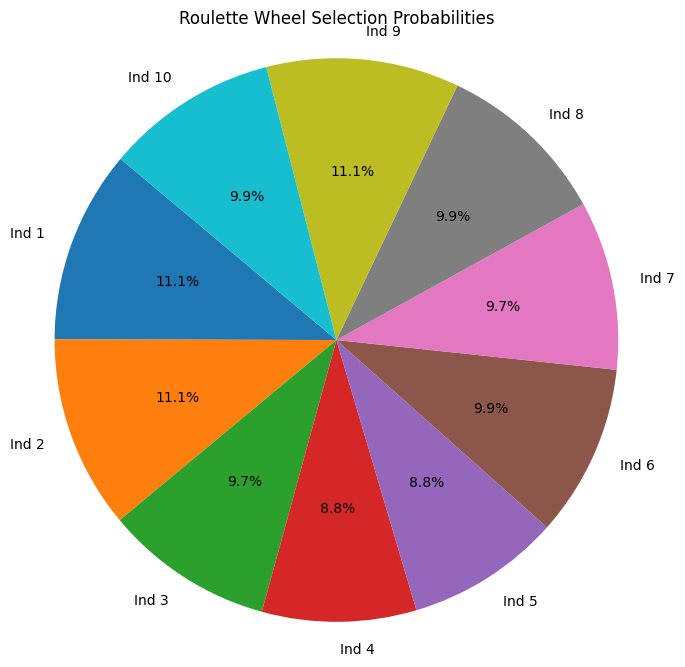

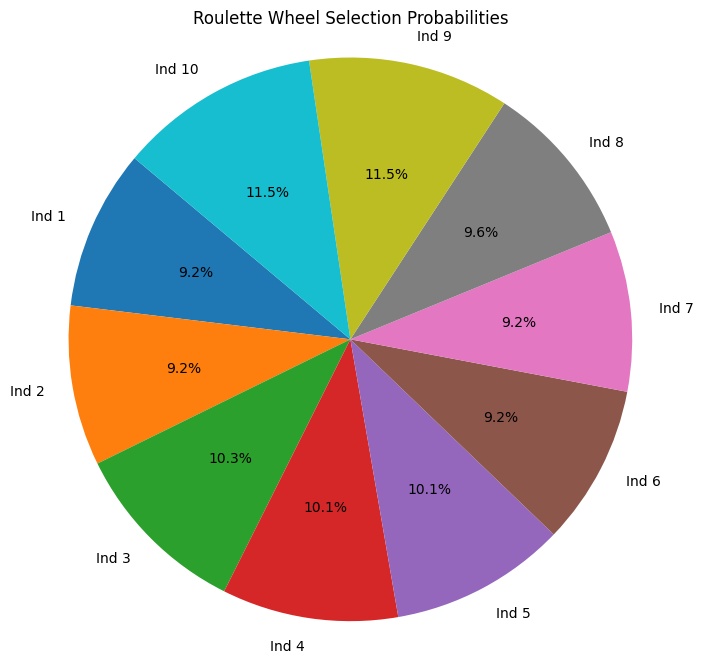

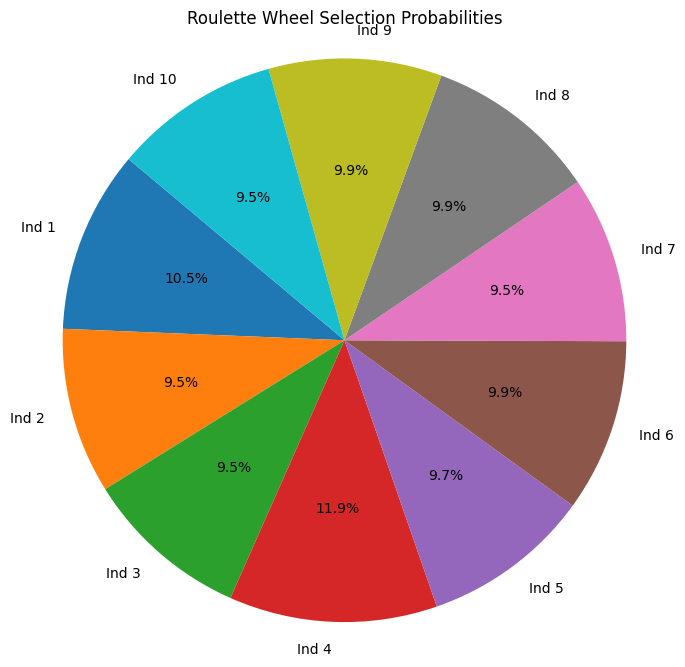

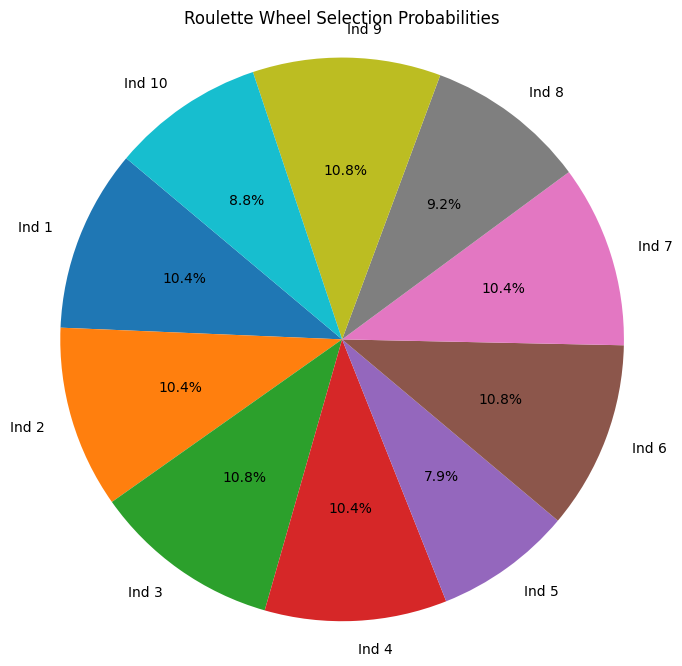

Best route after 100 generations: [('Bangalore', 2), ('Hyderabad', 3), ('Kolkata', 4), ('Delhi', 0), ('Mumbai', 1)]
Best route fitness: 0.0002007835814625746


In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.exc import GeocoderTimedOut
import time

# Initialize geolocator
geolocator = Nominatim(user_agent="tsp-geolocator", timeout=10)

# Cities and their coordinates setup (truncated for brevity, see original)
cities = ["Delhi", "Mumbai", "Bangalore", "Hyderabad", "Kolkata"]  # Add all cities as needed
city_coordinates = {}

# Get coordinates
def get_coordinates(city, retries=3):
    for attempt in range(retries):
        try:
            location = geolocator.geocode(city + ", India")
            if location:
                return (location.latitude, location.longitude)
            else:
                return None
        except GeocoderTimedOut:
            time.sleep(2)
    return None

for city in cities:
    coordinates = get_coordinates(city)
    if coordinates:
        city_coordinates[city] = coordinates

city_df = pd.DataFrame.from_dict(city_coordinates, orient='index', columns=['Latitude', 'Longitude'])

# Distance matrix calculation
def calculate_distance_matrix(city_df):
    cities = city_df.index
    distance_matrix = pd.DataFrame(index=cities, columns=cities)
    for city1 in cities:
        for city2 in cities:
            if city1 == city2:
                distance_matrix.loc[city1, city2] = 0
            else:
                coord1 = (city_df.loc[city1, 'Latitude'], city_df.loc[city1, 'Longitude'])
                coord2 = (city_df.loc[city2, 'Latitude'], city_df.loc[city2, 'Longitude'])
                distance_matrix.loc[city1, city2] = geodesic(coord1, coord2).kilometers
    return distance_matrix

distance_matrix = calculate_distance_matrix(city_df)
distance_array = distance_matrix.to_numpy()

# Generate initial population
def create_initial_population(population_size, city_names):
    population = []
    for _ in range(population_size):
        route_indices = np.random.permutation(len(city_names)).tolist()
        route = [(city_names[i], i) for i in route_indices]
        population.append(route)
    return population

population_size = 20
num_cities = len(cities)
initial_population = create_initial_population(population_size, cities)

# Fitness function
def calculate_route_distance(route, distance_matrix):
    total_distance = 0
    num_cities = len(route)
    for i in range(num_cities):
        current_city_index = route[i][1]
        next_city_index = route[(i + 1) % num_cities][1]
        total_distance += distance_matrix[current_city_index, next_city_index]
    return total_distance

def calculate_fitness(route, distance_matrix):
    total_distance = calculate_route_distance(route, distance_matrix)
    return 1 / total_distance if total_distance > 0 else float('inf')

# Roulette Wheel Selection
def roulette_wheel_selection(population, fitness_values, num_parents):
    total_fitness = sum(fitness_values)
    selection_probs = np.array(fitness_values) / total_fitness
    selection_probs = selection_probs / selection_probs.sum()
    parents_indices = np.random.choice(len(population), size=num_parents, p=selection_probs)
    parents = [population[i] for i in parents_indices]
    return parents

# Crossover function
def order_crossover(parent1, parent2):
    length = len(parent1)
    start, end = sorted(random.sample(range(length), 2))
    offspring = [None] * length
    offspring[start:end + 1] = parent1[start:end + 1]
    pos = (end + 1) % length
    for city in parent2:
        if city not in offspring:
            offspring[pos] = city
            pos = (pos + 1) % length
    return offspring

def crossover_population(parents, crossover_prob=0.6):
    offspring = []
    num_parents = len(parents)
    for i in range(0, num_parents - 1, 2):
        parent1, parent2 = parents[i], parents[i + 1]
        if random.random() < crossover_prob:
            child1 = order_crossover(parent1, parent2)
            child2 = order_crossover(parent2, parent1)
            offspring.extend([child1, child2])
        else:
            offspring.extend([parent1, parent2])
    if num_parents % 2 != 0:
        offspring.append(parents[-1])
    return offspring

# Mutation function
def mutate_route(route, mutation_prob=0.1):
    mutated_route = route[:]
    if random.random() < mutation_prob:
        idx1, idx2 = random.sample(range(len(route)), 2)
        mutated_route[idx1], mutated_route[idx2] = mutated_route[idx2], mutated_route[idx1]
    return mutated_route

def mutate_population(population, mutation_prob=0.1):
    return [mutate_route(route, mutation_prob) for route in population]

# Roulette Wheel Selection Plot Function
def plot_selection_probs(selection_probs):
    plt.figure(figsize=(8, 8))
    plt.pie(selection_probs, labels=[f"Ind {i+1}" for i in range(len(selection_probs))], autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title("Roulette Wheel Selection Probabilities")
    plt.show()

# Genetic Algorithm Main Loop
num_generations = 100
mutation_prob = 0.2
crossover_prob = 0.6

current_population = initial_population
for generation in range(num_generations):
    fitness_values = [calculate_fitness(route, distance_array) for route in current_population]
    selected_parents = roulette_wheel_selection(current_population, fitness_values, num_parents=10)
    
    # Plot selection probabilities every 10 generations
    if generation % 10 == 0:
        selection_probs = np.array(fitness_values) / sum(fitness_values)
        plot_selection_probs(selection_probs)

    offspring_population = crossover_population(selected_parents, crossover_prob)
    current_population = mutate_population(offspring_population, mutation_prob)

# Display final population's best route and fitness
best_route = max(current_population, key=lambda route: calculate_fitness(route, distance_array))
print("Best route after 100 generations:", best_route)
print("Best route fitness:", calculate_fitness(best_route, distance_array))
